
# Predicting Air Traffic Delay in the US



Why do flights delay? there could be actually many different reasons ranging from Weather conditions or Air carrier delays to Aircraft arriving late. A quick google search may reveal some of these reasons e.g. [here](http://www.mro-network.com/maintenance-repair-overhaul/top-5-reasons-flight-delays), and [here](http://www.businessinsider.com/why-your-flight-is-delayed-2016-8). How can we better understand?


#### Learning from statistics

Can we use machine learning to gain some more insight about the delay reasons from the published statistics? Yes.
For that purpose, several supervised ML models are trained in this notebook on air traffic data for the period of 2016/6 - 2017/5 for US domestic passenger flights$^1$ (around 5 million flights).

The problem was configured as a classification problem in two phases:

- **Binary classification** phase: where data were divided into two classes `delayed` or `not`.
- **Multi-class classification**: where data were divided into 5 classes depending on the delay length.


The idea is as follow:

1. check which flights were delayed (based on a delay variable in the dataset e.g. DEP_DELAY) and label them accordingly.
2. remove any information that indicates the flight were delayed (i.e. any delay-related variable).
3. given the labeled data, train a model on the other variables.
4. evaluate the model results to see which variables (i.e. feature importance) contributed most to the learned model.


Surprisingly, the destination of a flight was on the top (e.g. states like ND, SD, WY, KS). And less surprising, Air carrier was responsible for the delay in other cases. The departure time of the day is also a factor (the figure below).


![](assets/README-03d65.png)


<hr>

> $^1$The datasets are downloaded from [Bureau of Transportation Stats](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time).<br>

> $^2$ Note: this problem can also be configured as a regression problem, where we try to estimate the delay time. However, for simplicity lets stick to classification only in this demo.




## TOC


1. [Binary classification](#binary)

    1. [Load and process the data](#binary-load)
    2. [predicting whether a flight is delayed or not](#binary-train)
        - [using CatBoost](#binary-catboost)
        - [using XGBoost](#binary-xgboost)
        - [using Keras](#binary-keras)

2. [Multi-class classification](#cat)
    1. [Load and process data](#cat-load)
    2. [Predicting delay length by blocks](#cat-train)

        - [using CatBoost](#cat-catboost)
        - [using XGBoost](#cat-xgboost)
        - [using Keras](#cat-keras)    
  
3. [Visualizing traffic delay](#visualize)


<hr>
> Libraries used in this demo: `pandas`, `numpy`, `matplotlib`, `scikit-learn`, `Keras`, `XGBoost`, and `CatBoost`.


<hr>

# 1) Binary classification <a class="anchor" id="binary"></a>

$\ldots$ where a classifier attempt to predict whether a flight is (will be) delayed or not.
<hr>



## 1.1 Loading the US air traffic data and preprocessing with binary labels <a class='anchor' id='binary-load'></a>

Before training the binary estimators, air traffic data need to be processed with binary labels (delayed 1 or not 0).<br>
The threshold is set to 20 minutes based on the departure delay (i.e. 20 minutes delay or more is considered positive "1", otherwise negative "0" if less)

In [12]:
from input_data import us_air_traffic_data

data_bin = us_air_traffic_data(label_type='binary', DELAY_THRESHOLD=20)

reading air traffic data ...  
../data/air_traffic/42250968_T_ONTIME_2016_10.zip
../data/air_traffic/42250968_T_ONTIME_2016_11.zip
../data/air_traffic/42250968_T_ONTIME_2016_12.zip
../data/air_traffic/42250968_T_ONTIME_2016_6.zip
../data/air_traffic/42250968_T_ONTIME_2016_7.zip
../data/air_traffic/42250968_T_ONTIME_2016_8.zip
../data/air_traffic/42250968_T_ONTIME_2016_9.zip
../data/air_traffic/42250968_T_ONTIME_2017_1.zip
../data/air_traffic/42250968_T_ONTIME_2017_2.zip
../data/air_traffic/42250968_T_ONTIME_2017_3.zip
../data/air_traffic/42250968_T_ONTIME_2017_4.zip
../data/air_traffic/42250968_T_ONTIME_2017_5.zip
	data shape: (5631775, 49)
adding lat/long info ... 
	data shape: (5631775, 53)
preparing labels ... 
15.43% of the total flights were delayed 20 minutes or more.

final prepared data shape: (1738342, 54)


In [13]:
from input_data import transofrm_data

X_bin, y_bin, df_bin = transofrm_data(data_bin.copy(), binary=True)
df_bin.shape

normalizing and preparing training data ...


(1738342, 24)

In [3]:
df_bin.sample(2)

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER,ORIGIN,ORIGIN_STATE_ABR,ORIGIN_WAC,DEST,...,TAXI_IN,ARR_TIME_BLK,DIVERTED,AIR_TIME,DISTANCE,DISTANCE_GROUP,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE
1302481,2016,2,6,7,2,WN,HOU,TX,74,BNA,...,0.0,1000-1059,0.0,0.0,1000.0,3,30.0,-100.0,40.0,-90.0
1067414,2016,3,8,6,6,EV,PIA,IL,41,ORD,...,10.0,1600-1659,0.0,0.0,0.0,1,40.0,-90.0,40.0,-90.0


split to train/test

In [4]:
from sklearn.model_selection import train_test_split

print('splitting ... ')
X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_bin, y_bin, test_size=0.1)
print('train: ', (len(X_trainb), len(X_trainb[0])) )
print('test: ',  (len(X_testb), len(X_testb[0])) )

splitting ... 
train:  (1564507, 24)
test:  (173835, 24)


## 1.2 Training binary classifiers <a class="anchor" id="binary-train"></a>
<hr>

### Binary Classification: Gradient boosting trees with CatBoost <a class="anchor" id="binary-catboost"></a>

In [73]:

from catboost import CatBoostClassifier

def catboost_clf(X, y, epoch=80, eval_n=0.18):
    
    model = CatBoostClassifier(iterations=epoch, depth=5, verbose=True, use_best_model=True)
    x1, x2, y1, y2 = train_test_split(X, y, test_size=eval_n)
    model.fit(x1, y1, eval_set=(x2, y2))

    return model

print('training ..\n')
model = catboost_clf(X_trainb, y_trainb, epoch=50)

training ..

Borders generated
0:	learn 0.6577878749	test 0.6578229801	bestTest 0.6578229801	passed: 1.29 sec	total: 5.6s	remaining: 4m 34s
1:	learn 0.6278818941	test 0.627943356	bestTest 0.627943356	passed: 1.73 sec	total: 7.33s	remaining: 2m 56s
2:	learn 0.6027175937	test 0.602805092	bestTest 0.602805092	passed: 1.57 sec	total: 8.9s	remaining: 2m 19s
3:	learn 0.5799407865	test 0.5800308198	bestTest 0.5800308198	passed: 1.31 sec	total: 10.2s	remaining: 1m 57s
4:	learn 0.5586521929	test 0.5587618468	bestTest 0.5587618468	passed: 1.23 sec	total: 11.4s	remaining: 1m 42s
5:	learn 0.5438775213	test 0.5440012766	bestTest 0.5440012766	passed: 1.19 sec	total: 12.6s	remaining: 1m 32s
6:	learn 0.5315570564	test 0.5316950805	bestTest 0.5316950805	passed: 1.19 sec	total: 13.8s	remaining: 1m 24s
7:	learn 0.5212040988	test 0.5213519457	bestTest 0.5213519457	passed: 1.2 sec	total: 15s	remaining: 1m 18s
8:	learn 0.5111705241	test 0.5113318508	bestTest 0.5113318508	passed: 1.2 sec	total: 16.2s	remaini

In [78]:
# evaluate
train_score = model.score(X_trainb, y_trainb)
test_score = model.score(X_testb, y_testb)
print('train acc: {:.2f}%'.format(train_score))
print('test acc: {:.2f}%'.format(test_score))

train acc: 0.82%
test acc: 0.82%


### Binary Classification: Gradient boosting trees with XGBoost <a class="anchor" id="binary-xgboost"></a>

In [86]:
%%time


import xgboost as xgb

cols = df_bin.columns.tolist()

    
params = {'eta': 0.01,
          'max_depth': 5,
          'objective':'binary:logistic', 
          'silent': True, 
          'seed': 7}

x1, x2, y1, y2 = train_test_split(X_trainb, y_trainb, test_size=0.15, random_state=i)

dtrain= xgb.DMatrix(x1, y1, feature_names=cols)
deval = xgb.DMatrix(x2, y2, feature_names=cols)
watch = [(dtrain, 'train'), (deval, 'valid')]
model_xgb = xgb.train(params, dtrain, 1000, watch, verbose_eval=100, early_stopping_rounds=100)
    

print('best score: ', model_xgb.best_score)

# Eval
tdata = xgb.DMatrix(X_testb, y_testb, feature_names=cols)
print(model_xgb.eval(tdata))

[0]	train-error:0.400093	valid-error:0.40067
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.394956	valid-error:0.39565
[200]	train-error:0.392068	valid-error:0.392957
[300]	train-error:0.390242	valid-error:0.391086
[400]	train-error:0.388465	valid-error:0.389254
[500]	train-error:0.387843	valid-error:0.388658
[600]	train-error:0.386356	valid-error:0.387034
[700]	train-error:0.385596	valid-error:0.386207
[800]	train-error:0.38523	valid-error:0.385935
[900]	train-error:0.384831	valid-error:0.385462
best score:  0.38495
b'[0]\teval-error:0.384922'
CPU times: user 1h 52min 4s, sys: 43 s, total: 1h 52min 47s
Wall time: 35min 43s


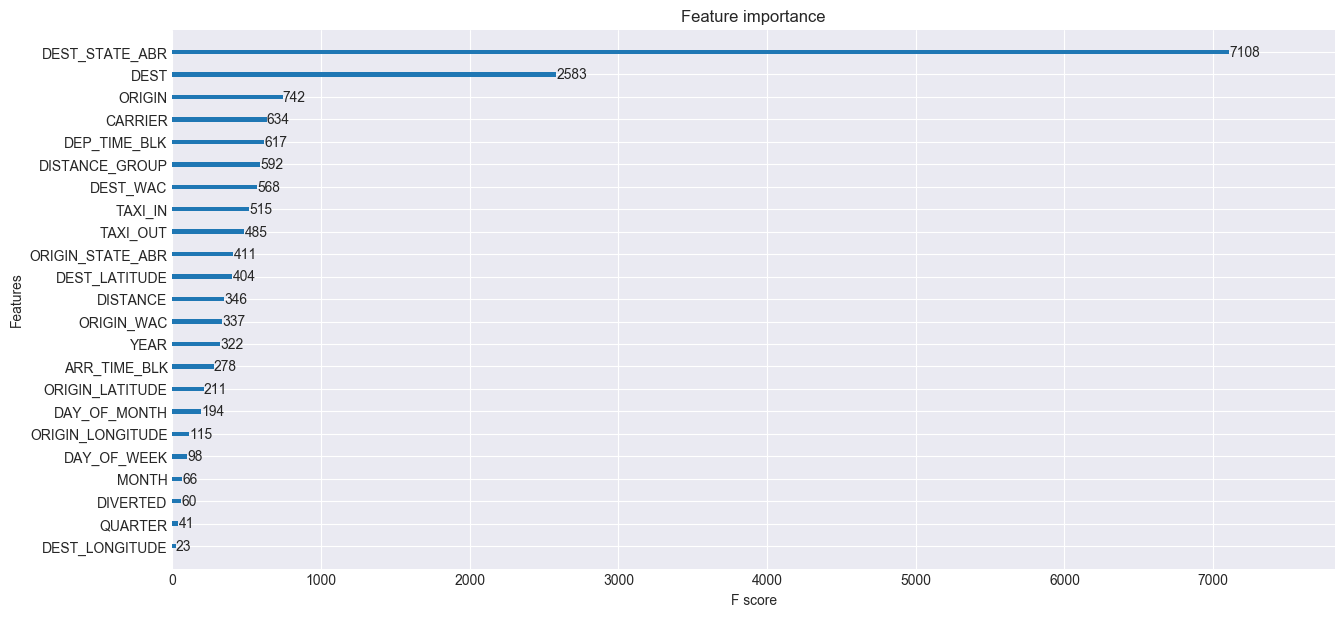

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt

# XGBoost feature importances

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (15, 7.0)

xgb.plot_importance(booster=model_xgb)
plt.show()

### Binary Classification: Neural network with Keras <a class="anchor" id="binary-keras"></a>

In [9]:
import keras
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

from util import plot_me

Using TensorFlow backend.


In [33]:
%%time

def baseline_model(input_dim=24):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['acc'])
    return model


estimator = KerasClassifier(build_fn=baseline_model, epochs=30, batch_size=256)

print('fitting ...')
losses = estimator.fit(X_trainb, y_trainb, validation_split=0.18, verbose=2)

print('evaluating ...')
loss, acc = estimator.model.evaluate(Xt, yt, verbose=2)
print('loss:\t\t{}\naccuracy:\t{:.2f}%\n'.format(loss, acc * 100))

fitting ...
Train on 1282895 samples, validate on 281612 samples
Epoch 1/30
13s - loss: 0.6226 - acc: 0.6049 - val_loss: 0.6199 - val_acc: 0.6038
Epoch 2/30
12s - loss: 0.6121 - acc: 0.6124 - val_loss: 0.6078 - val_acc: 0.6079
Epoch 3/30
13s - loss: 0.6074 - acc: 0.6167 - val_loss: 0.6066 - val_acc: 0.6147
Epoch 4/30
12s - loss: 0.6054 - acc: 0.6197 - val_loss: 0.6045 - val_acc: 0.6251
Epoch 5/30
12s - loss: 0.6049 - acc: 0.6200 - val_loss: 0.6022 - val_acc: 0.6261
Epoch 6/30
12s - loss: 0.6042 - acc: 0.6211 - val_loss: 0.6061 - val_acc: 0.6226
Epoch 7/30
12s - loss: 0.6035 - acc: 0.6217 - val_loss: 0.6012 - val_acc: 0.6262
Epoch 8/30
14s - loss: 0.6040 - acc: 0.6213 - val_loss: 0.6013 - val_acc: 0.6249
Epoch 9/30
12s - loss: 0.6035 - acc: 0.6216 - val_loss: 0.6058 - val_acc: 0.6144
Epoch 10/30
13s - loss: 0.6041 - acc: 0.6208 - val_loss: 0.6085 - val_acc: 0.6204
Epoch 11/30
12s - loss: 0.6052 - acc: 0.6198 - val_loss: 0.6058 - val_acc: 0.6112
Epoch 12/30
13s - loss: 0.6023 - acc: 0.62

In [110]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.figsize'] = (4, 3.0)

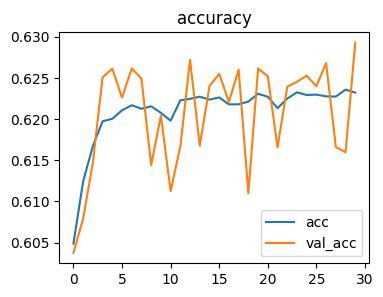

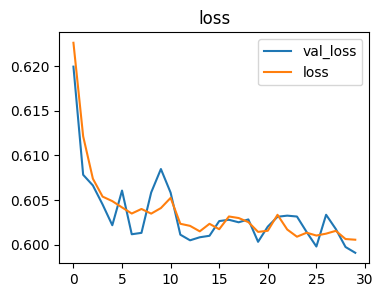

In [111]:
plot_me(losses)

<hr>
# 2) Multi-classification <a class="anchor" id="cat"></a>

$\ldots$ where a classifier attempt to predict the `DELAY_CLASS` for each flight (out of five groups).
<hr>


## 2.1 loading the US air traffic data and preprocessing with multi-class labels <a class="anchor" id="cat-load"></a>

First lets start by loading the datasets and label the samples with the correct class.

The data were divided into 5 classes (referred to as "`DELAY_CLASS`") based on the **departure delay time** as follows: 
- 0 (no dealy or less than five minutes), 
- 1 (delay time between 5-20minutes), 
- 2 (delay time between 20-60minutes), 
- 3 (delay time between 60-120minutes), and 
- 4 (delay time more than 2hours)

In [2]:
%%time
data = us_air_traffic_data(label_type='multiclass')

reading air traffic data ...  
../data/air_traffic/42250968_T_ONTIME_2016_10.zip
../data/air_traffic/42250968_T_ONTIME_2016_11.zip
../data/air_traffic/42250968_T_ONTIME_2016_12.zip
../data/air_traffic/42250968_T_ONTIME_2016_6.zip
../data/air_traffic/42250968_T_ONTIME_2016_7.zip
../data/air_traffic/42250968_T_ONTIME_2016_8.zip
../data/air_traffic/42250968_T_ONTIME_2016_9.zip
../data/air_traffic/42250968_T_ONTIME_2017_1.zip
../data/air_traffic/42250968_T_ONTIME_2017_2.zip
../data/air_traffic/42250968_T_ONTIME_2017_3.zip
../data/air_traffic/42250968_T_ONTIME_2017_4.zip
../data/air_traffic/42250968_T_ONTIME_2017_5.zip
	data shape: (5631775, 49)
adding lat/long info ... 
	data shape: (5631775, 53)
preparing labels ... 

final prepared data shape: (659890, 54)
CPU times: user 1min 17s, sys: 25.1 s, total: 1min 42s
Wall time: 1min 45s


In [4]:
X, y, df = transofrm_data(data.copy(), categorical=True)

normalizing and preparing training data ...


In [8]:
print('splitting ... ')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print('train: ', (len(X_train), len(X_train[0])) )
print('test: ',  (len(X_test), len(X_test[0])) )

splitting ... 
train:  (593901, 24)
test:  (65989, 24)


## 2.2 Training multi-class 'categorical' classifiers <a class="anchor" id="cat-train"></a>
<hr>

### Categorical classification:  Gradient boosting trees with _CatBoost_ <a class="anchor" id="cat-catboost"></a>

In [15]:
%%time

model = CatBoostClassifier(iterations=30, depth=5, verbose=True, use_best_model=True, loss_function='MultiClass')

# split train/eval
x1, x2, y1, y2 = train_test_split(X_train, y_train, test_size=0.18)
# fit
loss = model.fit(x1, y1, eval_set=(x2, y2))

Borders generated
0:	learn -1.59545248	test -1.595356127	bestTest -1.595356127	passed: 3.63 sec	total: 5.58s	remaining: 50.2s
1:	learn -1.582593346	test -1.582418393	bestTest -1.582418393	passed: 3.75 sec	total: 9.32s	remaining: 37.3s
2:	learn -1.569087442	test -1.568837769	bestTest -1.568837769	passed: 3.77 sec	total: 13.1s	remaining: 30.6s
3:	learn -1.556760805	test -1.556419796	bestTest -1.556419796	passed: 3.54 sec	total: 16.6s	remaining: 24.9s
4:	learn -1.545371636	test -1.544946731	bestTest -1.544946731	passed: 3.54 sec	total: 20.2s	remaining: 20.2s
5:	learn -1.534260542	test -1.533746724	bestTest -1.533746724	passed: 3.56 sec	total: 23.7s	remaining: 15.8s
6:	learn -1.524591078	test -1.523980544	bestTest -1.523980544	passed: 3.5 sec	total: 27.2s	remaining: 11.7s
7:	learn -1.51402146	test -1.513350853	bestTest -1.513350853	passed: 3.47 sec	total: 30.7s	remaining: 7.68s
8:	learn -1.504474245	test -1.503734232	bestTest -1.503734232	passed: 3.4 sec	total: 34.1s	remaining: 3.79s
9:	le

In [17]:
from util import features_report

importance = model.feature_importances(X_train, y_train)
cols = df.columns.tolist()

In [18]:
print(importance)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.7368473527395175, 0.0, 0.0, 2.3954407532023683, 35.69709929151329, 55.95690970240032, 1.013486535112477, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6025087002257207, 0.0, 0.0, 2.6201411877675866, 0.9775664770387107]


In [19]:
features_report(cols, importance)

[('DEST_STATE_ABR', 55.95690970240032),
 ('DEST', 35.69709929151329),
 ('DEST_LATITUDE', 2.6201411877675866),
 ('ORIGIN_WAC', 2.3954407532023683),
 ('DEST_WAC', 1.013486535112477),
 ('DEST_LONGITUDE', 0.9775664770387107),
 ('CARRIER', 0.7368473527395175),
 ('DISTANCE_GROUP', 0.6025087002257207),
 ('ORIGIN_LATITUDE', 0.0),
 ('MONTH', 0.0),
 ('DAY_OF_MONTH', 0.0),
 ('ARR_TIME_BLK', 0.0),
 ('TAXI_IN', 0.0)]

### Categorical classification: Gradient boosting trees with XGBoost <a class="anchor" id="cat-xgboost"></a>

In [21]:
%%time


params = {'eta': 0.01,
          'max_depth': 5,
          'objective': 'multi:softprob',
          'eval_metric': 'mlogloss',
          'num_class': 5,
          'silent': True
        }

x1, x2, y1, y2 = train_test_split(X_train, y_train, test_size=0.15)

dtrain= xgb.DMatrix(x1, y1, feature_names=df.columns.tolist())
deval = xgb.DMatrix(x2, y2, feature_names=df.columns.tolist())
watch = [(dtrain, 'train'), (deval, 'valid')]
model_xgb = xgb.train(params, dtrain, 500, watch, verbose_eval=50, early_stopping_rounds=50)
    

# print('best score: ', model_xgb.best_score)

print('\nevaluate: ')
tdata = xgb.DMatrix(X_test, y_test, feature_names=df.columns.tolist())
print(model_xgb.eval(tdata))

[0]	train-mlogloss:1.6067	valid-mlogloss:1.60672
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[50]	train-mlogloss:1.51538	valid-mlogloss:1.51616
[100]	train-mlogloss:1.47368	valid-mlogloss:1.47484
[150]	train-mlogloss:1.44695	valid-mlogloss:1.44822
[200]	train-mlogloss:1.42751	valid-mlogloss:1.42888
[250]	train-mlogloss:1.41294	valid-mlogloss:1.41427
[300]	train-mlogloss:1.40132	valid-mlogloss:1.40256
[350]	train-mlogloss:1.38948	valid-mlogloss:1.39074
[400]	train-mlogloss:1.37813	valid-mlogloss:1.37942
[450]	train-mlogloss:1.37092	valid-mlogloss:1.37222

evaluate: 
b'[0]\teval-mlogloss:1.370439'
CPU times: user 1h 12min 4s, sys: 22 s, total: 1h 12min 25s
Wall time: 21min 32s


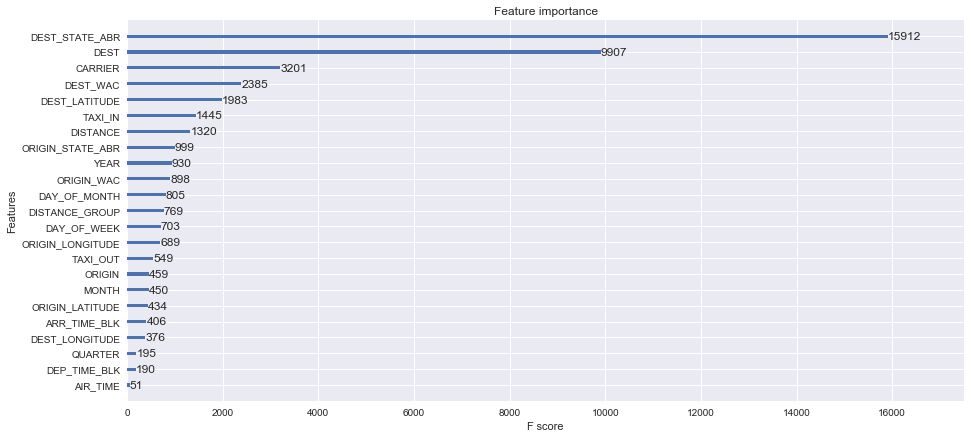

In [23]:
# XGBoost feature importances
plt.rcParams['figure.figsize'] = (15, 7.0)

xgb.plot_importance(booster=model_xgb)
plt.show()

### Categorical classification:  Neural networks with Keras <a class="anchor" id="cat-keras"></a>

In [12]:
%%time


from keras.utils import to_categorical

adam = Adam(lr=0.001)

def baseline_model(input_dim=24):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])
    return model


estimator = KerasClassifier(build_fn=baseline_model, epochs=30, batch_size=128)

Xt, yt = X_train, to_categorical(y_train)

losses = estimator.fit(Xt, yt, validation_split=0.18, verbose=2)

print('evaluating ...')
loss, acc = estimator.model.evaluate(Xt, yt, verbose=2)
print('loss:\t\t{}\naccuracy:\t{:.2f}%\n'.format(loss, acc * 100))

Train on 486998 samples, validate on 106903 samples
Epoch 1/30
42s - loss: 1.5441 - acc: 0.2673 - val_loss: 1.5364 - val_acc: 0.2744
Epoch 2/30
42s - loss: 1.5373 - acc: 0.2724 - val_loss: 1.5326 - val_acc: 0.2763
Epoch 3/30
41s - loss: 1.5334 - acc: 0.2748 - val_loss: 1.5274 - val_acc: 0.2757
Epoch 4/30
41s - loss: 1.5293 - acc: 0.2760 - val_loss: 1.5227 - val_acc: 0.2801
Epoch 5/30
47s - loss: 1.5263 - acc: 0.2771 - val_loss: 1.5202 - val_acc: 0.2814
Epoch 6/30
44s - loss: 1.5238 - acc: 0.2787 - val_loss: 1.5177 - val_acc: 0.2842
Epoch 7/30
47s - loss: 1.5219 - acc: 0.2796 - val_loss: 1.5159 - val_acc: 0.2839
Epoch 8/30
43s - loss: 1.5201 - acc: 0.2797 - val_loss: 1.5158 - val_acc: 0.2852
Epoch 9/30
54s - loss: 1.5194 - acc: 0.2807 - val_loss: 1.5138 - val_acc: 0.2850
Epoch 10/30
51s - loss: 1.5185 - acc: 0.2810 - val_loss: 1.5128 - val_acc: 0.2848
Epoch 11/30
49s - loss: 1.5180 - acc: 0.2813 - val_loss: 1.5113 - val_acc: 0.2856
Epoch 12/30
46s - loss: 1.5175 - acc: 0.2812 - val_loss

:( Need more time, or maybe better features? but it still can learn see the plots

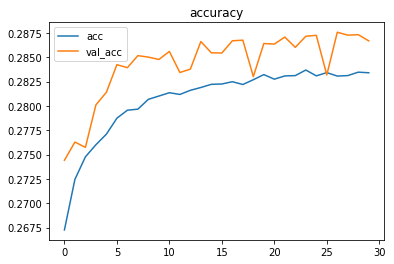

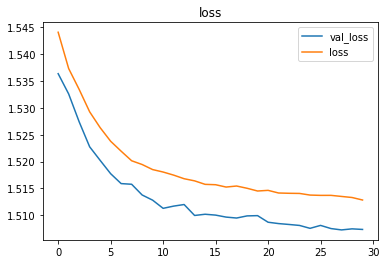

In [13]:
plot_me(losses)

<hr>
# 3) Visualizing Air Traffic Delay <a class="anchor" id="visualize"></a>
<hr>


Driven by the feature importances from the estimators' results, lets visualize some of the delay factors.

In [20]:
import pandas as pd
plt.style.use('seaborn-dark')

In [26]:
df = data.copy() # data before preoprocessing e.g. us_air_traffic_data(label_type='multiclass')
target = ['DEP_DELAY', 'ARR_DELAY'] # target columns

def delay_by(INDEX, plot=True, top_n=60, size=(15,10)):
    target = ['DEP_DELAY', 'ARR_DELAY']
    temp = pd.pivot_table(df, index=[INDEX])
    if plot:
        temp.sort_values(by=target[0])[target][-top_n:].plot.barh(figsize=size, grid=1);
        return
    return temp

Lets see the top arrivale/departure delay by state name `DEST_STATE_ABR`

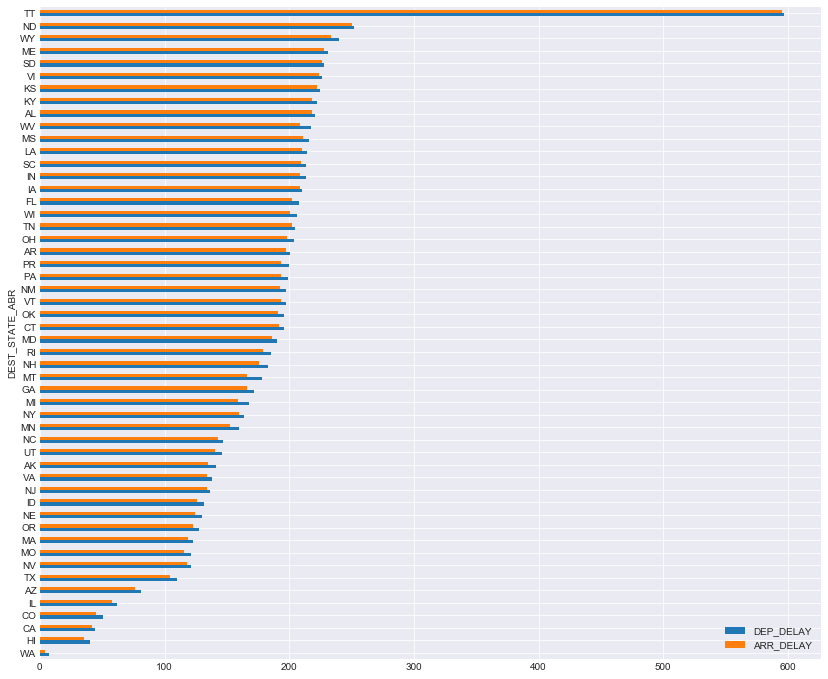

In [28]:
delay_by('DEST_STATE_ABR', size=(14,12))

Lets see the top delaying Air Carrier

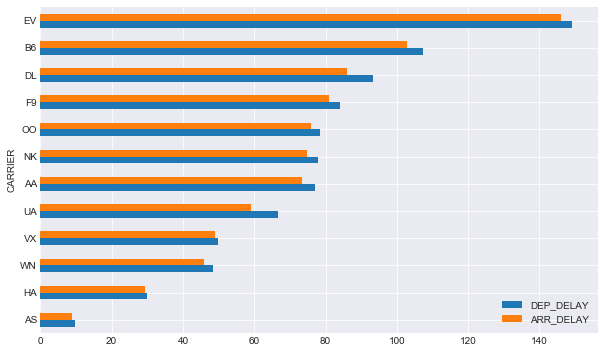

In [32]:
delay_by('CARRIER', size=(10,6))

Which day the week has most delayed flights? Hmm .. Monday, Sunday, then Friday!!

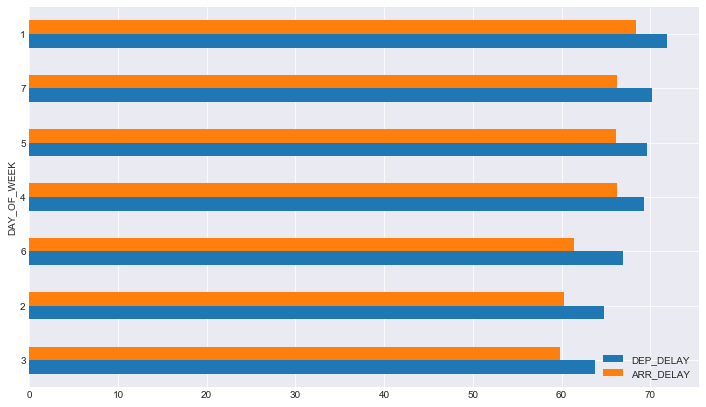

In [34]:
delay_by('DAY_OF_WEEK', size=(12,7))

<hr>
End.

In [35]:
!date

Mon Jul 24 12:52:43 EDT 2017
